## **Initial Configuration**

In [ ]:
# download of the dataset, already divided into training and test
!wget -L "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/test_bodies.csv" "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/test_stances_unlabeled.csv" "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_bodies.csv"  "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_stances.csv" "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/train_stances.random.csv" "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_bodies.csv"  "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_stances.csv" "https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/29d473af2d15278f0464d5e41e4cbe7eb58231f2/competition_test_stances_unlabeled.csv" 

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/HLT/dataset
!mkdir /content/drive/MyDrive/HLT/base_model

!cp -r . /content/drive/MyDrive/HLT/dataset

!rm -r /content/drive/MyDrive/HLT/dataset/drive
!ls /content/drive/MyDrive/HLT/dataset

## **Initial import and utilities**

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

!pip install -q tf-models-official
!pip install -q -U tensorflow-text 

import tensorflow_hub as hub
import tensorflow_text as text

from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from official.nlp import optimization 
from google.colab import drive

tf.get_logger().setLevel('ERROR')

In [ ]:
NUM_CLASSES=4

BERT_MODEL="https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
BERT_PREPROCESS_MODEL="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

MODEL_DIR="/content/drive/MyDrive/HLT"

BATCH_SIZE=32   
LABELS=['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED=['unrelated','related']
RELATED=LABELS[0:3]
TARGET_COLUMN="Stance"

In [ ]:
# utilities
def plot_metrics(history):
  '''Plot the progress of metrics during network training'''
  metrics = ['loss', 'accuracy', 'precision_training', 'recall_training', 'f1_training']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.figure(figsize=(8, 6), dpi=200)
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()


def plot_metric_parameter(metric, parameter, labels, x_name, y_name, y_lim=-1):
  '''Plot the value of metrics against network parameter'''
  plt.figure(figsize=(10, 4), dpi=1200)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  
  if y_lim != -1:
    plt.ylim(y_lim[0],y_lim[1])

  i = 0
  for x,y in zip(parameter, metric):
    
    label = labels[i]
    i += 1
    plt.text(x+.03, y+.05, label, fontsize=9)
    plt.scatter(x, y, marker='o', color='blue')
    
  plt.show()


def get_class_distribution(data):
  '''Get cardinality of classes, given a dataframe'''
  agree = data.Stance.value_counts().agree
  disagree = data.Stance.value_counts().disagree
  discuss = data.Stance.value_counts().discuss
  unrelated = data.Stance.value_counts().unrelated

  return agree, disagree, discuss, unrelated


def plot_class_distribution(data_annot, name):
  '''Plot histograms with data distribution'''
  class_distribution = get_class_distribution(data_annot)
  class_distribution = {LABELS[i]: class_distribution[i] for i in range(len(LABELS))}

  fig, axes = plt.subplots(figsize=(5,len(class_distribution)))
  plt.bar(class_distribution.keys(), height=class_distribution.values())
  plt.title(f'Barplot of class distribution of {name} dataset')


def get_length_statistics(data):
  len_data = []
  for text in data:
    len_data.append(len(text.split()))

  return min(len_data), max(len_data), np.mean(np.array(len_data))
  

def get_confusion_matrix(gold_labels, pred_labels):
  '''Compute the confusion matrix, given gold and predicted labels'''   
  confusion_matrix = [[0, 0, 0, 0],   
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]]

  for i, (g, t) in enumerate(zip(gold_labels, pred_labels)):
      confusion_matrix[LABELS.index(g)][LABELS.index(t)] += 1

  return confusion_matrix


def build_data_pipeline(annot):
  '''Creates a tensorflow Dataset from a Dataframe'''
  AUTOTUNE = tf.data.AUTOTUNE

  headline = annot.Headline.map(str)  # headline -> str
  articleBody = annot.articleBody.map(str)  # articleBody -> str
  labels = annot[TARGET_COLUMN].cat.codes  # integer labels of categories

  data = tf.data.Dataset.from_tensor_slices(("[HEAD]" + headline + "[BODY]" + articleBody, labels))

  return data.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


def get_dataset(dir, sample=-1):
  '''Creates a unique dataframe combining the information contained in the two separeted documents in which the dataset is provided

     Inputs:
        - dir: to specify the directory from which the dataset has to be loaded.
        - sample: to specify whether the dataset should be built with only a portion of the directory contents.
     
     Returns:
        - If is specified the training directory: the training and the validation dataset, along with their dataframe. 
        - Otherwise returns the whole dataset with the corresponding dataframe.
  '''
  data_bodies = pd.read_csv(dir + "_bodies.csv")
  data_stances = pd.read_csv(dir + "_stances.csv")

  join_data =  pd.merge(data_stances, data_bodies, how="inner", on=["Body ID"])
  join_data = join_data[['Body ID', 'Headline', 'articleBody', 'Stance']]

  join_data[TARGET_COLUMN] = join_data[TARGET_COLUMN].astype('category')

  if sample > 0:
    join_data = join_data.sample(100)

  if dir == "train":
    train_annot, val_annot = train_test_split(join_data, test_size=0.2, random_state=42, shuffle=True, stratify=join_data[TARGET_COLUMN])
    train_ds = build_data_pipeline(train_annot)
    val_ds = build_data_pipeline(val_annot)

    return train_ds, val_ds, train_annot, val_annot
  else:
    data_ds = build_data_pipeline(join_data)

    return data_ds, join_data


def score_metrics(gold_labels, pred_labels):
  '''Computes the score metrics of the FNC-1 challenge given the gold and predicted labels'''
  score = 0.0
  for i, (g, t) in enumerate(zip(gold_labels, pred_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

  return score


def get_predictions(data_ds, data_annot, model_used, include_softMax=False):
  '''Given a model and a dataset returns the gold and predicted labels'''
  gold_labels = data_annot[TARGET_COLUMN].to_numpy()
  
  prediction = model_used.predict(data_ds)

  if include_softMax:
    prediction = tf.nn.softmax(prediction).numpy()

  pred_labels = prediction.argmax(axis=1)
  pred_labels = np.array([LABELS[i] for i in pred_labels])

  return pred_labels, gold_labels

In [ ]:
# copy all the dataset
drive.mount('/content/drive')
 
!cp /content/drive/MyDrive/HLT/dataset/* .
!ls

## **Dataset Visualization**

In [ ]:
# visualization of dataset
train_bodies = pd.read_csv("train_bodies.csv")
train_stances = pd.read_csv("train_stances.csv")

print(f'Number of training samples in the training set: {train_stances.shape[0]}')
train_stances.head()

Number of training samples in the training set: 49972


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [ ]:
# count and show unique number of headline in the training set
print(f'Number of unique headline in the training set: {train_stances["Headline"].nunique()}')
train_stances.groupby(['Headline'])['Stance'].agg(lambda x: ','.join(x.dropna())).reset_index().head()

Number of unique headline in the training set: 1648


,Headline,Stance
0,"""Categorically False"": DHS Debunks Right-Wing ...","discuss,unrelated,disagree,unrelated,unrelated..."
1,"""Oldest Time Capsule"" in U.S. Unearthed in Boston","unrelated,unrelated,unrelated,unrelated,discus..."
2,"""This is the recording you thought you'd lost ...","unrelated,unrelated,unrelated,agree,unrelated,..."
3,"#Daysofdarkness: No, There Won't Be Six Days O...","agree,unrelated,unrelated,unrelated,agree,unre..."
4,#HairGate: iPhone 6 Customers Are Complaining ...,"discuss,unrelated,unrelated,unrelated,discuss,..."


In [ ]:
# count and show unique number of body in the training set
print(f'Number of unique Body in the training set: {train_bodies.shape[0]}')
train_bodies.head()

Number of unique Body in the training set: 1683


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [ ]:
# get the two training sets available on github and verify that are equal
test_competition_bodies = pd.read_csv("competition_test_bodies.csv")
test_competition_stances = pd.read_csv("competition_test_stances.csv")
test_competition_stances_un = pd.read_csv("competition_test_stances_unlabeled.csv")

test_bodies = pd.read_csv("test_bodies.csv")
test_stances = pd.read_csv("test_stances_unlabeled.csv")

print(test_competition_stances_un.equals(test_stances))
print(test_competition_bodies.equals(test_bodies))

True
True


In [ ]:
# count and show unique samples in the test set
print(f'Number of training samples in the test set: {test_competition_stances.shape[0]}')
test_competition_stances.head()

Number of training samples in the test set: 25413


,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [ ]:
# count and show unique number of headline in the test set
print(f'Number of unique headline in the test set: {test_competition_stances["Headline"].nunique()}')
test_competition_stances.groupby(['Headline'])['Stance'].agg(lambda x: ','.join(x.dropna())).reset_index().head()

Number of unique headline in the test set: 894


,Headline,Stance
0,"""Jihadi John"" reportedly wounded in airstrike","unrelated,unrelated,unrelated,unrelated,unrela..."
1,"""When We Felt Threatened, We Opened Umbrellas ...","discuss,unrelated,unrelated,unrelated,unrelate..."
2,'Crabzilla' or 'Crapzilla' -- You Decide,"unrelated,unrelated,unrelated,unrelated,unrela..."
3,'Dear Sandwich Thief': Man's hilarious respons...,"unrelated,unrelated,unrelated,unrelated,unrela..."
4,"'Even though you're gay, I will always treat y...","unrelated,unrelated,agree,agree,agree,agree,un..."


In [ ]:
# count and show unique number of body in the test set
print(f'Number of unique Body in the test set: {test_competition_bodies.shape[0]}')
test_competition_bodies.head()

Number of unique Body in the test set: 904


,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [ ]:
# refactor of dataset
join_train =  pd.merge(train_stances, train_bodies, how="inner", on=["Body ID"])
join_train = join_train[['Body ID', 'Headline', 'articleBody', 'Stance']]
join_train.head()

,Body ID,Headline,articleBody,Stance
0,712,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,unrelated
1,712,Seth Rogen to Play Apple’s Steve Wozniak,Danny Boyle is directing the untitled film\n\n...,discuss
2,712,Mexico police find mass grave near site 43 stu...,Danny Boyle is directing the untitled film\n\n...,unrelated
3,712,Mexico Says Missing Students Not Found In Firs...,Danny Boyle is directing the untitled film\n\n...,unrelated
4,712,New iOS 8 bug can delete all of your iCloud do...,Danny Boyle is directing the untitled film\n\n...,unrelated


In [ ]:
# training/validation split
join_train[TARGET_COLUMN] = join_train[TARGET_COLUMN].astype('category')

\begin{tabular}{lrr}
\toprule
    Stance &  Cardinality &  Percentage \\
\midrule
 unrelated &        36545 &    0.731310 \\
   discuss &         8909 &    0.178280 \\
     agree &         3678 &    0.073601 \\
  disagree &          840 &    0.016809 \\
\bottomrule
\end{tabular}



,Stance,Cardinality,Percentage
0,unrelated,36545,0.731310
1,discuss,8909,0.178280
2,agree,3678,0.073601
3,disagree,840,0.016809


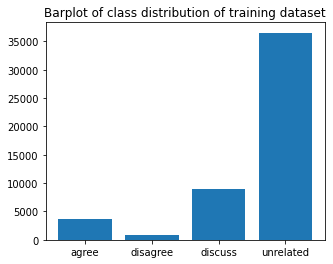

In [ ]:
plot_class_distribution(join_train, "training")
distribution_table = join_train[TARGET_COLUMN].value_counts().rename_axis('Stance').reset_index(name='Cardinality')
distribution_table['Percentage'] = distribution_table.apply(lambda row: row.Cardinality/ distribution_table['Cardinality'].sum(), axis=1)
print(distribution_table.to_latex(index=False))
distribution_table

\begin{tabular}{lrr}
\toprule
    Stance &  Cardinality &  Percentage \\
\midrule
 unrelated &        18349 &    0.722032 \\
   discuss &         4464 &    0.175658 \\
     agree &         1903 &    0.074883 \\
  disagree &          697 &    0.027427 \\
\bottomrule
\end{tabular}



,Stance,Cardinality,Percentage
0,unrelated,18349,0.722032
1,discuss,4464,0.175658
2,agree,1903,0.074883
3,disagree,697,0.027427


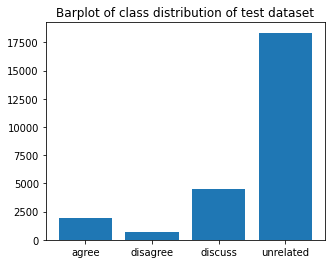

In [ ]:
test_annot = pd.read_csv("competition_test_stances.csv")
plot_class_distribution(test_annot, "test")
distribution_table = test_annot[TARGET_COLUMN].value_counts().rename_axis('Stance').reset_index(name='Cardinality')
distribution_table['Percentage'] = distribution_table.apply(lambda row: row.Cardinality/ distribution_table['Cardinality'].sum(), axis=1)
print(distribution_table.to_latex(index=False))
distribution_table

In [ ]:
col_1 = ['Headline', 'agree', 'disagree', 'discuss', 'unrelated']
col_2 = ['Robert Plant Ripped up $800M Led Zeppelin Reunion Contract', 'Led Zeppelin’s Robert Plant turned down £500 MILLION to reform supergroup', 'No, Robert Plant did not rip up an $800 million deal to get Led Zeppelin back together', 'Robert Plant reportedly tore up an $800 million Led Zeppelin reunion deal', 'Richard Branson’s Virgin Galactic is set to launch SpaceShipTwo today']
raw_data = {'a': col_1, 'b': col_2}
df = pd.DataFrame(raw_data)
print(df.to_latex())
df

In [ ]:
# Get information about size of headline and articleBody
min_head, max_head, mean_head = get_length_statistics(headline)
min_body, max_body, mean_body = get_length_statistics(articleBody)

print(f'Min head: {min_head}, Max head: {max_head}, Mean head: {mean_head}')
print(f'Min body: {min_body}, Max body: {max_body}, Mean body: {mean_body}')

In [ ]:
# input data/label visualization
train_annot, val_annot = train_test_split(join_train, test_size=0.2, random_state=42, shuffle=True, stratify=join_train[TARGET_COLUMN])

train_ds = build_data_pipeline(train_annot)
val_ds = build_data_pipeline(val_annot)

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({LABELS[label]})')

In [ ]:
# preprocessed data visualization
preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')
text_test = ['NLP is such an amazing topic!', 'yessss man that\'s right']
text_preprocessed = preprocessing_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
encoder = hub.KerasLayer(BERT_MODEL, trainable=False, name='BERT_encoder')

encoder_output = encoder(text_preprocessed)

print(f'Pooled Outputs Shapes:{encoder_output["pooled_output"].shape}')       # return a ndarray of size [batch_size, H] and represents each input sequence as a whole,
                                                                              # so can be used as a sentence embedding.

print(f'Sequence Outputs Shapes:{encoder_output["sequence_output"].shape}')   # returns a ndarray of size [batch_size, seq_length, H], where seq_length is 128 by default and H is equal to Hidden size.
                                                                              # So it returns a contextual word embedding for every token in the sentence.

print(f'Encoder Outputs Len:{len(encoder_output["encoder_outputs"])}')        # returns a list of size L, where L is equal to the number of stacked encoders and each
                                                                              # element of the list has size equal to [batch_size, seq_length, H]

print(f'Pooled Outputs Values:{encoder_output["pooled_output"][0, :12]}')
print(f'Sequence Outputs Values:{encoder_output["sequence_output"][0, :12]}')

print(f'First encoder output Shape:{encoder_output["encoder_outputs"][0].shape}')
print(f'First encoder output Values:{encoder_output["encoder_outputs"][0][0, :12]}')

print(f'Last encoder output Shape:{encoder_output["encoder_outputs"][-1].shape}')
print(f'Last encoder output Values:{encoder_output["encoder_outputs"][-1][0, :12]}')

## **Base Model**

In [ ]:
# utilities for metrics monitoring during training
def f1_training(y_true, y_pred):     
    """ Calculate the micro f1, so globally by counting the total true positives, false negatives and false positives.""" 
    precision = precision_training(y_true, y_pred)
    recall = recall_training(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def recall_training(y_true, y_pred):
    """ Calculate the recall, so globally by counting the total true positives, false negatives and false positives.""" 
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall


def precision_training(y_true, y_pred):
    """ Calculate the precision, so globally by counting the total true positives, false negatives and false positives.""" 
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
# utilities for model construction
def get_model(seq_length):
  """Returns the model constructed with a functional API"""
  text_input = layers.Input(shape=(), dtype=tf.string, name='text')
  if seq_length == 128:
    preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
  else:
    preprocessor = hub.load(BERT_PREPROCESS_MODEL)
    
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_input = tokenize(text_input)
    
    bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, arguments=dict(seq_length=seq_length)) 
    encoder_inputs = bert_pack_inputs([tokenized_input])
  
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = layers.Dropout(0.3)(net)
  net = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(net)
    
  model = tf.keras.Model(text_input, net)

  return model


# model compilation
def get_compiled_model(epochs, seq_length=128):
  """Returns a compiled model.
  Args:
      - epochs (int): an integer that express the number of epochs needed to train the model, used to initialize the optimizer.
  """
  steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  init_lr = 3e-5
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #in fact labels are not one-hot encoded

  metrics = ['accuracy', 
              f1_training,
              recall_training,
              precision_training]

  model= get_model(seq_length)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

In [ ]:
train_ds, val_ds, train_annot, val_annot = get_dataset("train")

In [ ]:
# Count samples per class
class_agree = train_annot[train_annot['Stance'] == "agree"]
class_disagree = train_annot[train_annot['Stance'] == "disagree"]
class_discuss = train_annot[train_annot['Stance'] == "discuss"]
class_unrelated = train_annot[train_annot['Stance'] == "unrelated"]

# Convert parts into NumPy arrays for weight computation
agree_numpy = class_agree['Stance'].to_numpy()
disagree_numpy = class_disagree['Stance'].to_numpy()
discuss_numpy = class_discuss['Stance'].to_numpy()
unrelated_numpy = class_unrelated['Stance'].to_numpy()

all_together = np.concatenate((agree_numpy, disagree_numpy, discuss_numpy, unrelated_numpy))
unique_classes = np.unique(all_together)       #Returns the sorted unique elements of an array

# Compute weights
weights = compute_class_weight('balanced', classes=unique_classes, y=all_together)

weights_dict = {i : weights[i] for i in range(len(weights))}
print(weights_dict)

{0: 3.397093813732155, 1: 14.872395833333334, 2: 1.4023081240353585, 3: 0.3418473799425366}


In [ ]:
epochs = 3
base_model = get_compiled_model(epochs, 512)

In [ ]:
# model training 
checkpoint = ModelCheckpoint(MODEL_DIR + "/base_model/bert_small_drive_trial",   
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

history_base = base_model.fit(train_ds,
                              validation_data=val_ds,
                              epochs=epochs,
                              callbacks=[checkpoint], 
                              #class_weight=weights_dict,
                              verbose=1)

In [ ]:
plot_metrics(history_base)

In [ ]:
#model saving
base_model.save(MODEL_DIR + "/base_model/bert_small_backup.h5", include_optimizer=False) 

## **Other Trials: add class weights**
Try again explicitly tokenizing and packing inputs to the encoder.

In [ ]:
train_ds, val_ds, train_annot, val_annot = get_dataset("train")
agree, disagree, discuss, unrelated = get_class_distribution(train_annot)

total = agree + disagree + discuss + unrelated

weight_agree = (1 / agree) * (total / 2.0)  #sklearn divide by 4
weight_disagree = (1 / disagree) * (total / 2.0)
weight_discuss = (1 / discuss) * (total / 2.0)
weight_unrelated = (1 / unrelated) * (total / 2.0)

class_weights = {0: weight_agree, 1: weight_disagree, 2: weight_discuss, 3: weight_unrelated}

print('Weight for class agree: {:.2f}'.format(weight_agree))
print('Weight for class disagree: {:.2f}'.format(weight_disagree))
print('Weight for class discuss: {:.2f}'.format(weight_discuss))
print('Weight for class unrelated: {:.2f}'.format(weight_unrelated))

Weight for class agree: 6.79
Weight for class disagree: 29.74
Weight for class discuss: 2.80
Weight for class unrelated: 0.68


In [ ]:
# Count samples per class
class_agree = train_annot[train_annot['Stance'] == "agree"]
class_disagree = train_annot[train_annot['Stance'] == "disagree"]
class_discuss = train_annot[train_annot['Stance'] == "discuss"]
class_unrelated = train_annot[train_annot['Stance'] == "unrelated"]

# Convert parts into NumPy arrays for weight computation
agree_numpy = class_agree['Stance'].to_numpy()
disagree_numpy = class_disagree['Stance'].to_numpy()
discuss_numpy = class_discuss['Stance'].to_numpy()
unrelated_numpy = class_unrelated['Stance'].to_numpy()

all_together = np.concatenate((agree_numpy, disagree_numpy, discuss_numpy, unrelated_numpy))
unique_classes = np.unique(all_together)       #Returns the sorted unique elements of an array

# Compute weights
weights = compute_class_weight('balanced', classes=unique_classes, y=all_together)

weights_dict = {i : weights[i] for i in range(len(weights))}
print(weights_dict)

In [ ]:
epochs = 3
class_weights_model = get_compiled_model(epochs)

class_weights_history = class_weights_model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=epochs,
                                  class_weight=class_weights,
                                  verbose=1)

Epoch 1/3
1250/1250 [==============================] - 585s 462ms/step - loss: 1.9252 - accuracy: 0.7943 - f1_training: 0.9059 - recall_training: 0.8536 - precision_training: 1.0000 - val_loss: 0.2481 - val_accuracy: 0.9121 - val_f1_training: 0.9886 - val_recall_training: 0.9778 - val_precision_training: 1.0000
Epoch 2/3
1250/1250 [==============================] - 578s 462ms/step - loss: 0.9927 - accuracy: 0.9388 - f1_training: 0.9938 - recall_training: 0.9879 - precision_training: 1.0000 - val_loss: 0.1562 - val_accuracy: 0.9503 - val_f1_training: 0.9968 - val_recall_training: 0.9938 - val_precision_training: 1.0000
Epoch 3/3
1250/1250 [==============================] - 577s 461ms/step - loss: 0.6463 - accuracy: 0.9650 - f1_training: 0.9979 - recall_training: 0.9958 - precision_training: 1.0000 - val_loss: 0.1272 - val_accuracy: 0.9622 - val_f1_training: 0.9985 - val_recall_training: 0.9970 - val_precision_training: 1.0000


In [ ]:
#model saving
class_weights_model.save(MODEL_DIR + "/base_model/class_weights_SEP.h5", include_optimizer=False)

In [ ]:
plot_metrics(class_weights_history)

## **Other Trials: oversampling**

In [ ]:
_, _, train_annot, _ = get_dataset("train")

# Get a distinct dataframe for each class
class_agree = train_annot[train_annot['Stance'] == "agree"]
class_disagree = train_annot[train_annot['Stance'] == "disagree"]
class_discuss = train_annot[train_annot['Stance'] == "discuss"]
class_unrelated = train_annot[train_annot['Stance'] == "unrelated"]

# Print sizes
print(f'Class 0: {len(class_agree)}')
print(f'Class 1: {len(class_disagree)}')
print(f'Class 2: {len(class_discuss)}')
print(f'Class 3: {len(class_unrelated)}')
print()

class_agree = class_agree.sample(int(len(class_unrelated)), replace=True)
class_disagree = class_disagree.sample(int(len(class_unrelated)), replace=True)
class_discuss = class_discuss.sample(int(len(class_unrelated)), replace=True)

# Print sampled sizes
print(f'Class 0: {len(class_agree)}')
print(f'Class 1: {len(class_disagree)}')
print(f'Class 2: {len(class_discuss)}')
print(f'Class 3: {len(class_unrelated)}')
print()

join_train = pd.concat([class_agree, class_disagree, class_discuss, class_unrelated])
train_annot, val_annot = train_test_split(join_train, test_size=0.2, random_state=42, shuffle=True, stratify=join_train[TARGET_COLUMN])

train_ds = build_data_pipeline(train_annot)
val_ds = build_data_pipeline(val_annot)
train_annot[TARGET_COLUMN].value_counts()

Class 0: 2942
Class 1: 672
Class 2: 7127
Class 3: 29236

Class 0: 29236
Class 1: 29236
Class 2: 29236
Class 3: 29236



unrelated    23389
disagree     23389
agree        23389
discuss      23388
Name: Stance, dtype: int64

In [ ]:
epochs = 3
oversampling_model = get_compiled_model(epochs)

history_oversampling = oversampling_model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=epochs,
                                  verbose=1)

Epoch 1/3
2924/2924 [==============================] - 1344s 456ms/step - loss: 0.4130 - accuracy: 0.8341 - f1_training: 0.9258 - recall_training: 0.8932 - precision_training: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9862 - val_f1_training: 0.9996 - val_recall_training: 0.9992 - val_precision_training: 1.0000
Epoch 2/3
2924/2924 [==============================] - 1332s 456ms/step - loss: 0.0383 - accuracy: 0.9891 - f1_training: 0.9998 - recall_training: 0.9997 - precision_training: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9967 - val_f1_training: 1.0000 - val_recall_training: 1.0000 - val_precision_training: 1.0000
Epoch 3/3
2924/2924 [==============================] - 1331s 455ms/step - loss: 0.0108 - accuracy: 0.9974 - f1_training: 1.0000 - recall_training: 1.0000 - precision_training: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9976 - val_f1_training: 1.0000 - val_recall_training: 1.0000 - val_precision_training: 1.0000


In [ ]:
oversampling_model.save(MODEL_DIR + "/base_model/oversampling_model_with_END.h5", include_optimizer=False)

In [ ]:
plot_metrics(history_oversampling)

## **Load and Test**

In [ ]:
MODEL_TO_LOAD = MODEL_DIR + "/base_model/bert_small_3_epochs.h5"

In [ ]:
model_loaded = tf.keras.models.load_model((MODEL_TO_LOAD),custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
# compute score on validation or test 
#test_ds, test_annot = get_dataset("competition_test")
train_ds, val_ds, train_annot, val_annot = get_dataset("train")

start_time = time.time()
#pred_labels, gold_labels = get_predictions(test_ds, test_annot, model_loaded)
pred_labels, gold_labels = get_predictions(val_ds, val_annot, model_loaded)
inference_time = time.time() - start_time
print(f'Inference time: {inference_time}')

Inference time: 62.856979846954346


[[608, 50, 66, 12], [67, 72, 28, 1], [42, 12, 1710, 18], [3, 1, 17, 7288]]


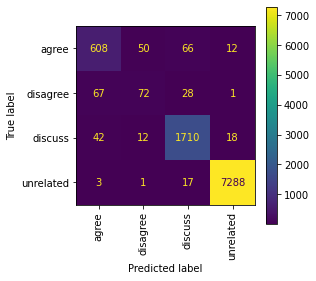

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, xticks_rotation='vertical', ax=ax)
score_test = score_metrics(pred_labels, gold_labels)
print(get_confusion_matrix(gold_labels, pred_labels))

In [ ]:
unrelated_num = val_annot.Stance.value_counts().unrelated
max_score = len(val_annot) - (unrelated_num * 0.75)
print(f'Score test: {score_test}/{max_score}, so {(score_test*100)/max_score}%')

Score test: 4278.25/4513.25, so 94.79310917852989%


In [ ]:
f1_summary = f1_score(gold_labels, pred_labels, average=None)
f1_micro = f1_score(gold_labels, pred_labels, average="micro")
f1_macro = f1_score(gold_labels, pred_labels, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.83516484 0.47524752 0.94920899 0.99644517]
0.9682841420710355
0.8140166315157876


## **MODEL COMPARISONS**

In [ ]:
def maximum_value_in_column(column):    
    highlight = 'font-weight: bold;text-align: center;'
    default = 'text-align: center;'

    maximum_in_column = column.max()

    # must return one string per cell in this column
    return [highlight if v == maximum_in_column else default for v in column]

def maximumspeed(column):    
    highlight = 'font-weight: bold; text-align: center'
    default = 'text-align: center;'

    maximum_in_column = column.max()

    # must return one string per cell in this column
    return [highlight if v == "x10" else default for v in column]

In [ ]:
import pandas as pd

#Comparison of all the models
models = ['BERT_base', 'BERT_large', 'BERT_expert', 'Small-BERT','BERT_talking', 'Albert', 'Electra']
parameter_size = ['108M', '334M', '108M', '29M', '110M', '12M', '14M']
parameter_size_num = [108, 334, 108, 29, 110, 12, 14]

FNC_score =   [87.0, 88.3, 88.7, 83.9, 87.6, 87.1, 85.1]
F1_macro =    [71.3, 74.2, 75.3, 60.3, 73.0, 72.0, 61.5]
F1_micro =    [92.0, 92.5, 93.0, 89.7, 92.4, 92.1, 90.2]
inference_time = [274, 740, 242, 73, 319, 241, 92]
speedup = ['x' + str(round(x/73)) for x in inference_time]
MNLI = [84.5, 86.6, '-', 82.8, 83.6, 81.6, 79.7]

raw_data = {'MODEL': models, 'Params': parameter_size, 'FNC-score': FNC_score, 'F1-macro': F1_macro, 'F1-micro': F1_micro, 'Inference time': inference_time, 'Speedup':speedup}
general_performances = pd.DataFrame(raw_data)
general_performances.style.apply(maximum_value_in_column, subset=['Params', 'FNC-score', 'F1-macro', 'F1-micro', 'Inference time'], axis=0).apply(maximumspeed, subset=['Speedup'], axis=0)
#print(general_performances.to_latex(index=False))

,MODEL,Params,FNC-score,F1-macro,F1-micro,Inference time,Speedup
0,BERT_base,108M,87.000000,71.300000,92.000000,274,x4
1,BERT_large,334M,88.300000,74.200000,92.500000,740,x10
2,BERT_expert,108M,88.700000,75.300000,93.000000,242,x3
3,Small-BERT,29M,83.900000,60.300000,89.700000,73,x1
4,BERT_talking,110M,87.600000,73.000000,92.400000,319,x4
5,Albert,12M,87.100000,72.000000,92.100000,241,x3
6,Electra,14M,85.100000,61.500000,90.200000,92,x1


In [ ]:

models = ['BERT_base', 'BERT_large', 'BERT_expert', 'Small-BERT', 'BERT_talking', 'Albert', 'Electra']
F1_agree =      [65.0, 69.5, 69.3, 56.8, 64.6, 59.8, 68.0]
F1_disagree =   [38.5, 45.4, 48.6,  8.0, 42.5, 42.3,  8.6]
F1_discuss =    [83.0, 83.2, 84.4, 78.2, 82.7, 82.5, 79.6] 
F1_unrelated =  [98.6, 98.9, 99.0, 98.1, 98.9, 98.7, 98.2]

raw_data = {'MODEL': models, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
F1_scores = pd.DataFrame(raw_data)
F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['agree', 'disagree', 'discuss', 'unrelated'], axis=0)
#print(F1_scores.to_latex(index=False, escape=False))                

MODEL,agree,disagree,discuss,unrelated
BERT_base,65.000000,38.500000,83.000000,98.600000
BERT_large,69.500000,45.400000,83.200000,98.900000
BERT_expert,69.300000,48.600000,84.400000,99.000000
Small-BERT,56.800000,8.000000,78.200000,98.100000
BERT_talking,64.600000,42.500000,82.700000,98.900000
Albert,59.800000,42.300000,82.500000,98.700000
Electra,68.000000,8.600000,79.600000,98.200000


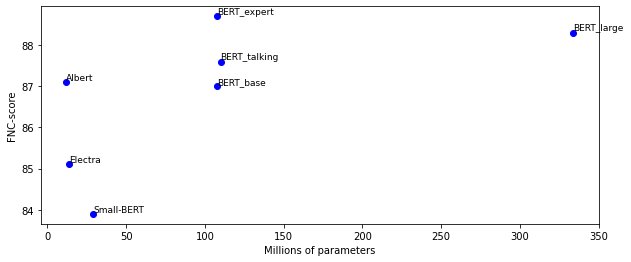

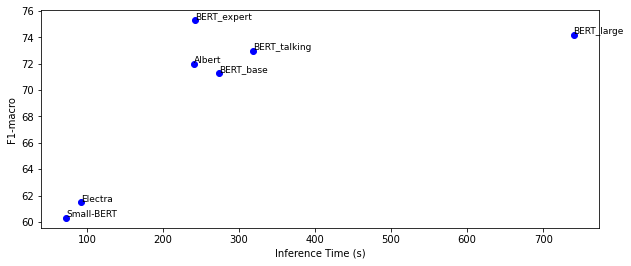

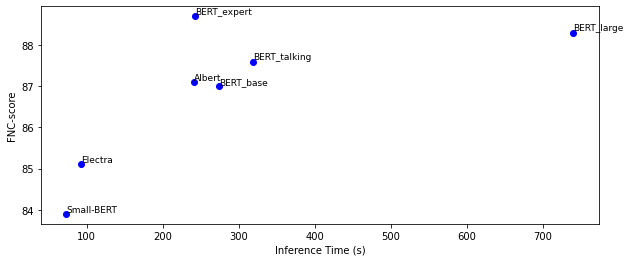

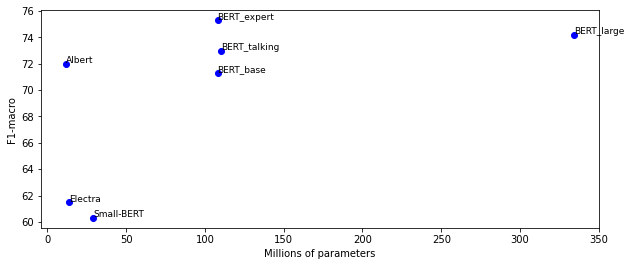

In [ ]:
plot_metric_parameter(FNC_score, parameter_size_num, models, "Millions of parameters", "FNC-score")
plot_metric_parameter(F1_macro, inference_time, models, "Inference Time (s)", "F1-macro")
plot_metric_parameter(FNC_score, inference_time, models, "Inference Time (s)", "FNC-score")
plot_metric_parameter(F1_macro, parameter_size_num, models, "Millions of parameters", "F1-macro")

In [ ]:
#COMPARISON SEQ LENGTH TEST

seq_length = [128, 512]
FNC_score = [83.9, 84.4]
F1_macro = [60.3, 60.1]
F1_micro = [89.7, 90.2]
inference_time = [73, 475]
speedup = ['x' + str(round(x/73)) for x in inference_time]

raw_data = {'Seq length': seq_length, 'FNC-score': FNC_score, 'F1-macro': F1_macro, 'F1-micro': F1_micro, 'Inference time': inference_time, 'Speedup':speedup}
df = pd.DataFrame(raw_data)
df.style.hide_index().apply(maximum_value_in_column, subset=['FNC-score', 'F1-macro', 'F1-micro', 'Inference time'], axis=0)#.apply(maximumspeed, subset=['Speedup'], axis=0)
#print(df.to_latex(index=False, escape=False))


Seq length,FNC-score,F1-macro,F1-micro,Inference time,Speedup
128,83.900000,60.300000,89.700000,73,x1
512,84.400000,60.100000,90.200000,475,x7


In [ ]:
#COMPARISON SEQ LENGTH TEST

seq_length = [128, 512]
F1_agree =      [56.8, 55.4]
F1_disagree =   [ 8.1, 7.9]
F1_discuss =    [78.2, 78.5] 
F1_unrelated =  [98.1, 98.7]

raw_data = {'Seq length': seq_length, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
df = pd.DataFrame(raw_data)
#print(df.to_latex(index=False, escape=False))
df

,Seq length,agree,disagree,discuss,unrelated
0,128,56.8,8.1,78.2,98.1
1,512,55.4,7.9,78.5,98.7


In [ ]:
#COMPARISON SEQ LENGTH VAL
seq_length = [128, 512]
FNC_score = [94.8, 95.0]
F1_macro = [81.4, 81.6]
F1_micro = [96.8, 96.9]
inference_time = [61, 221]
speedup = ['x' + str(round(x/61)) for x in inference_time]

raw_data = {'Seq length': seq_length, 'FNC-score': FNC_score, 'F1-macro': F1_macro, 'F1-micro': F1_micro, 'Inference time': inference_time, 'Speedup':speedup}
df = pd.DataFrame(raw_data)
#print(df.to_latex(index=False))
df

,Seq length,FNC-score,F1-macro,F1-micro,Inference time,Speedup
0,128,94.8,81.4,96.8,61,x1
1,512,95.0,81.6,96.9,221,x4


In [ ]:
#COMPARISON SEQ LENGTH VAL

seq_length = [128, 512]
F1_agree =      [56.8, 55.4]
F1_disagree =   [ 8.1, 7.9]
F1_discuss =    [78.2, 78.5] 
F1_unrelated =  [98.1, 98.7]

raw_data = {'Seq length': seq_length, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
df = pd.DataFrame(raw_data)
#print(df.to_latex(index=False))
df

,Seq length,agree,disagree,discuss,unrelated
0,128,56.8,8.1,78.2,98.1
1,512,55.4,7.9,78.5,98.7


In [ ]:
#COMPARISON EMBEDDINGS 

embeddings_type = ["Last only", "Concatted"]
FNC_score = [57.8, 60.4]
F1_macro = [39.7, 39.9]

raw_data = {'Embeddings type': embeddings_type, 'FNC-score': FNC_score, 'F1-macro': F1_macro}
df = pd.DataFrame(raw_data)
#print(df.to_latex(index=False))
df

,Embeddings type,FNC-score,F1-macro
0,Last only,57.8,39.7
1,Concatted,60.4,39.9


In [ ]:
#COMPARISON EMBEDDINGS 

embeddings_type = ["Last only", "Concatted"]
F1_agree =      [24.1, 74.0]
F1_disagree =   [21.0, 21.7]
F1_discuss =    [80.7, 88.7] 
F1_unrelated =  [95.6, 95.7]

raw_data = {'Embeddings type': embeddings_type, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
df = pd.DataFrame(raw_data)
#print(df.to_latex(index=False))
df

,Embeddings type,agree,disagree,discuss,unrelated
0,Last only,24.1,21.0,80.7,95.6
1,Concatted,74.0,21.7,88.7,95.7


In [ ]:
# COMPARISON NETWORK CONFIG

network_config = ["base", "window length=5", "augmented capacity"]
F1_agree =      [68.5, 74.0, 72.2]
F1_disagree =   [21.0, 21.7, 18.5]
F1_discuss =    [80.7, 88.7, 85.6] 
F1_unrelated =  [95.6, 95.7, 94.3]

raw_data = {'Network config': network_config, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
df = pd.DataFrame(raw_data)
print(df.to_latex(index=False))
df

\begin{tabular}{lrrrr}
\toprule
     Network config &  agree &  disagree &  discuss &  unrelated \\
\midrule
               base &   68.5 &      21.0 &     80.7 &       95.6 \\
    window length=5 &   74.0 &      21.7 &     88.7 &       95.7 \\
 augmented capacity &   72.2 &      18.5 &     85.6 &       94.3 \\
\bottomrule
\end{tabular}



,Network config,agree,disagree,discuss,unrelated
0,base,68.5,21.0,80.7,95.6
1,window length=5,74.0,21.7,88.7,95.7
2,augmented capacity,72.2,18.5,85.6,94.3


In [ ]:
# COMPARISON NETWORK CONFIG
network_config = ["base", "window length=5", "augmented capacity"]
FNC_score = [87.2, 89.6, 90.2]
F1_macro = [66.4, 70.0, 67.6]

raw_data = {'Network config': network_config, 'FNC-score': FNC_score, 'F1-macro': F1_macro}
df = pd.DataFrame(raw_data)
print(df.to_latex(index=False))
df

\begin{tabular}{lrr}
\toprule
     Network config &  FNC-score &  F1-macro \\
\midrule
               base &       87.2 &      66.4 \\
    window length=5 &       89.6 &      70.0 \\
 augmented capacity &       90.2 &      67.6 \\
\bottomrule
\end{tabular}



,Network config,FNC-score,F1-macro
0,base,87.2,66.4
1,window length=5,89.6,70.0
2,augmented capacity,90.2,67.6


In [ ]:
def plot_metric_parameter(metric, parameter, labels, x_name, y_name, y_lim=-1):
  '''Plot the value of metrics against network parameter'''
  #plt.plot(parameter, metric, 'bo-')
  plt.figure(figsize=(10, 4), dpi=80)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  
  if y_lim != -1:
    plt.ylim(y_lim[0],y_lim[1])

  i = 0
  for x,y in zip(parameter, metric):
    
    label = labels[i]
    i += 1
    plt.text(x+.03, y+.05, label, fontsize=9)
    plt.scatter(x, y, marker='o', color='blue')
    
  plt.show()

In [ ]:
import pandas as pd

#COMPARISON ALL MODEL 
models = ["Pretrained embeddings", 'BERT_base', 'BERT_large', 'BERT_expert', 'Small-BERT','BERT_talking', 'Albert', 'Electra']
parameter_size = ["-", '108M', '334M', '108M', '29M', '110M', '12M', '14M']
parameter_size_num = [108, 334, 108, 29, 110, 12, 14]

FNC_score =   [61.2, 65.7, 61.8, 60.2, 60.4, 62.5, 39.4, 57.4]
F1_macro =    [34.8, 42.6, 40.3, 39.1, 39.9, 40.9, 21.0, 37.7]
F1_micro =    [53.5, 70.1, 67.6, 66.4, 69.0, 68.8, 72.2, 64.8]
inference_time = [569, 1704, 563, 202, 743, 623, 203]
speedup = ['x' + str(round(x/202)) for x in inference_time]
inference_time.insert(0, 11)
speedup.insert(0, '-')
MNLI = ['-', 84.5, 86.6, '-', 82.8, 83.6, 81.6, 79.7]

raw_data = {'MODEL': models, 'Params': parameter_size, 'FNC-score': FNC_score, 'F1-macro': F1_macro, 'F1-micro': F1_micro, 'Inference time': inference_time, 'Speedup':speedup}
general_performances = pd.DataFrame(raw_data)
#general_performances.style.apply(maximum_value_in_column, subset=['Params', 'FNC-score', 'F1-macro', 'F1-micro', 'Inference time'], axis=0).apply(maximumspeed, subset=['Speedup'], axis=0)
print(general_performances.to_latex(index=False))

\begin{tabular}{llrrrrl}
\toprule
                 MODEL & Params &  FNC-score &  F1-macro &  F1-micro &  Inference time & Speedup \\
\midrule
 Pretrained embeddings &      - &       61.2 &      34.8 &      56.8 &              11 &       - \\
             BERT\_base &   108M &       65.7 &      42.6 &      70.1 &             569 &      x3 \\
            BERT\_large &   334M &       61.8 &      40.3 &      67.6 &            1704 &      x8 \\
           BERT\_expert &   108M &       60.2 &      39.1 &      66.4 &             563 &      x3 \\
            Small-BERT &    29M &       60.4 &      39.9 &      69.0 &             202 &      x1 \\
          BERT\_talking &   110M &       62.5 &      40.9 &      68.8 &             743 &      x4 \\
                Albert &    12M &       39.4 &      21.0 &      72.2 &             623 &      x3 \\
               Electra &    14M &       57.4 &      37.7 &      64.8 &             203 &      x1 \\
\bottomrule
\end{tabular}



In [ ]:
#COMPARISON ALL MODEL 
models = ["Pretrained embeddings", 'BERT_base', 'BERT_large', 'BERT_expert', 'Small-BERT', 'BERT_talking', 'Albert', 'Electra']
F1_agree =      [26.9, 35.5, 30.1, 29.3, 27.4, 30.4,    0, 27.3]
F1_disagree =   [0   ,    0, 0.2,  0.7,   0,   1.4,    0,  1.1]
F1_discuss =    [44.8, 51.6, 48.1, 46.6, 50.2, 48.5,  0.1, 44.6] 
F1_unrelated =  [67.6, 83.3, 82.8, 79.9, 82.1, 83.3, 83.9, 77.9]

raw_data = {'MODEL': models, 'agree': F1_agree, 'disagree': F1_disagree, 'discuss': F1_discuss, 'unrelated': F1_unrelated}
F1_scores = pd.DataFrame(raw_data)
#F1_scores.style.hide_index().apply(maximum_value_in_column, subset=['agree', 'disagree', 'discuss', 'unrelated'], axis=0)
print(F1_scores.to_latex(index=False, escape=False))                

\begin{tabular}{lrrrr}
\toprule
                 MODEL &  agree &  disagree &  discuss &  unrelated \\
\midrule
 Pretrained embeddings &   22.3 &       0.0 &     45.7 &       71.2 \\
             BERT_base &   35.5 &       0.0 &     51.6 &       83.3 \\
            BERT_large &   30.1 &       0.2 &     48.1 &       82.8 \\
           BERT_expert &   29.3 &       0.7 &     46.6 &       79.9 \\
            Small-BERT &   27.4 &       0.0 &     50.2 &       82.1 \\
          BERT_talking &   30.4 &       1.4 &     48.5 &       83.3 \\
                Albert &    0.0 &       0.0 &      0.1 &       83.9 \\
               Electra &   27.3 &       1.1 &     44.6 &       77.9 \\
\bottomrule
\end{tabular}



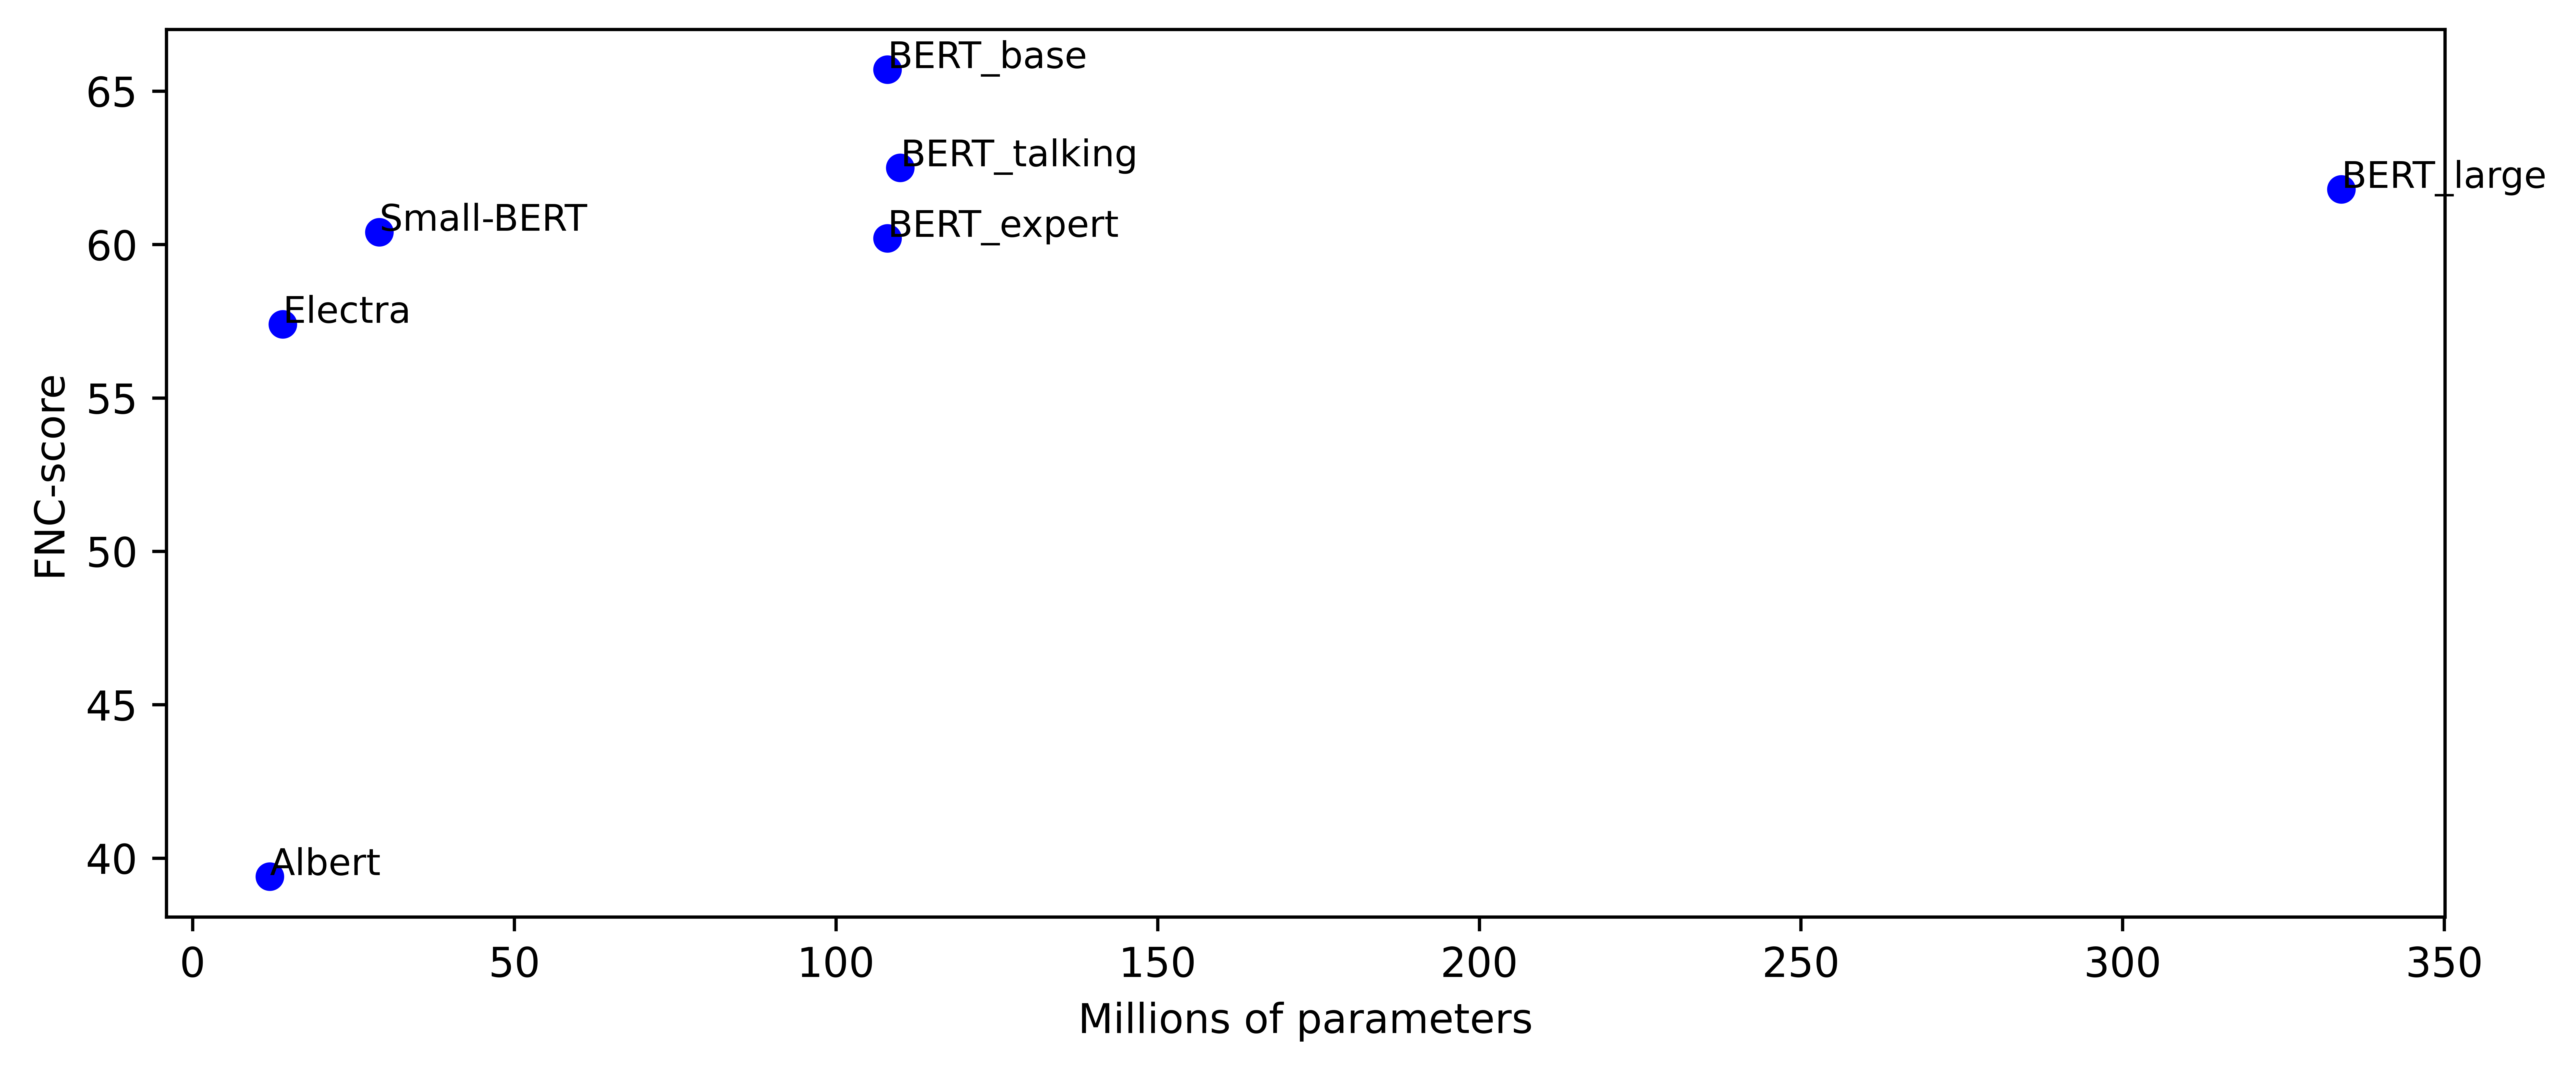

In [ ]:
plot_metric_parameter(FNC_score[1:], parameter_size_num, models[1:], "Millions of parameters", "FNC-score")

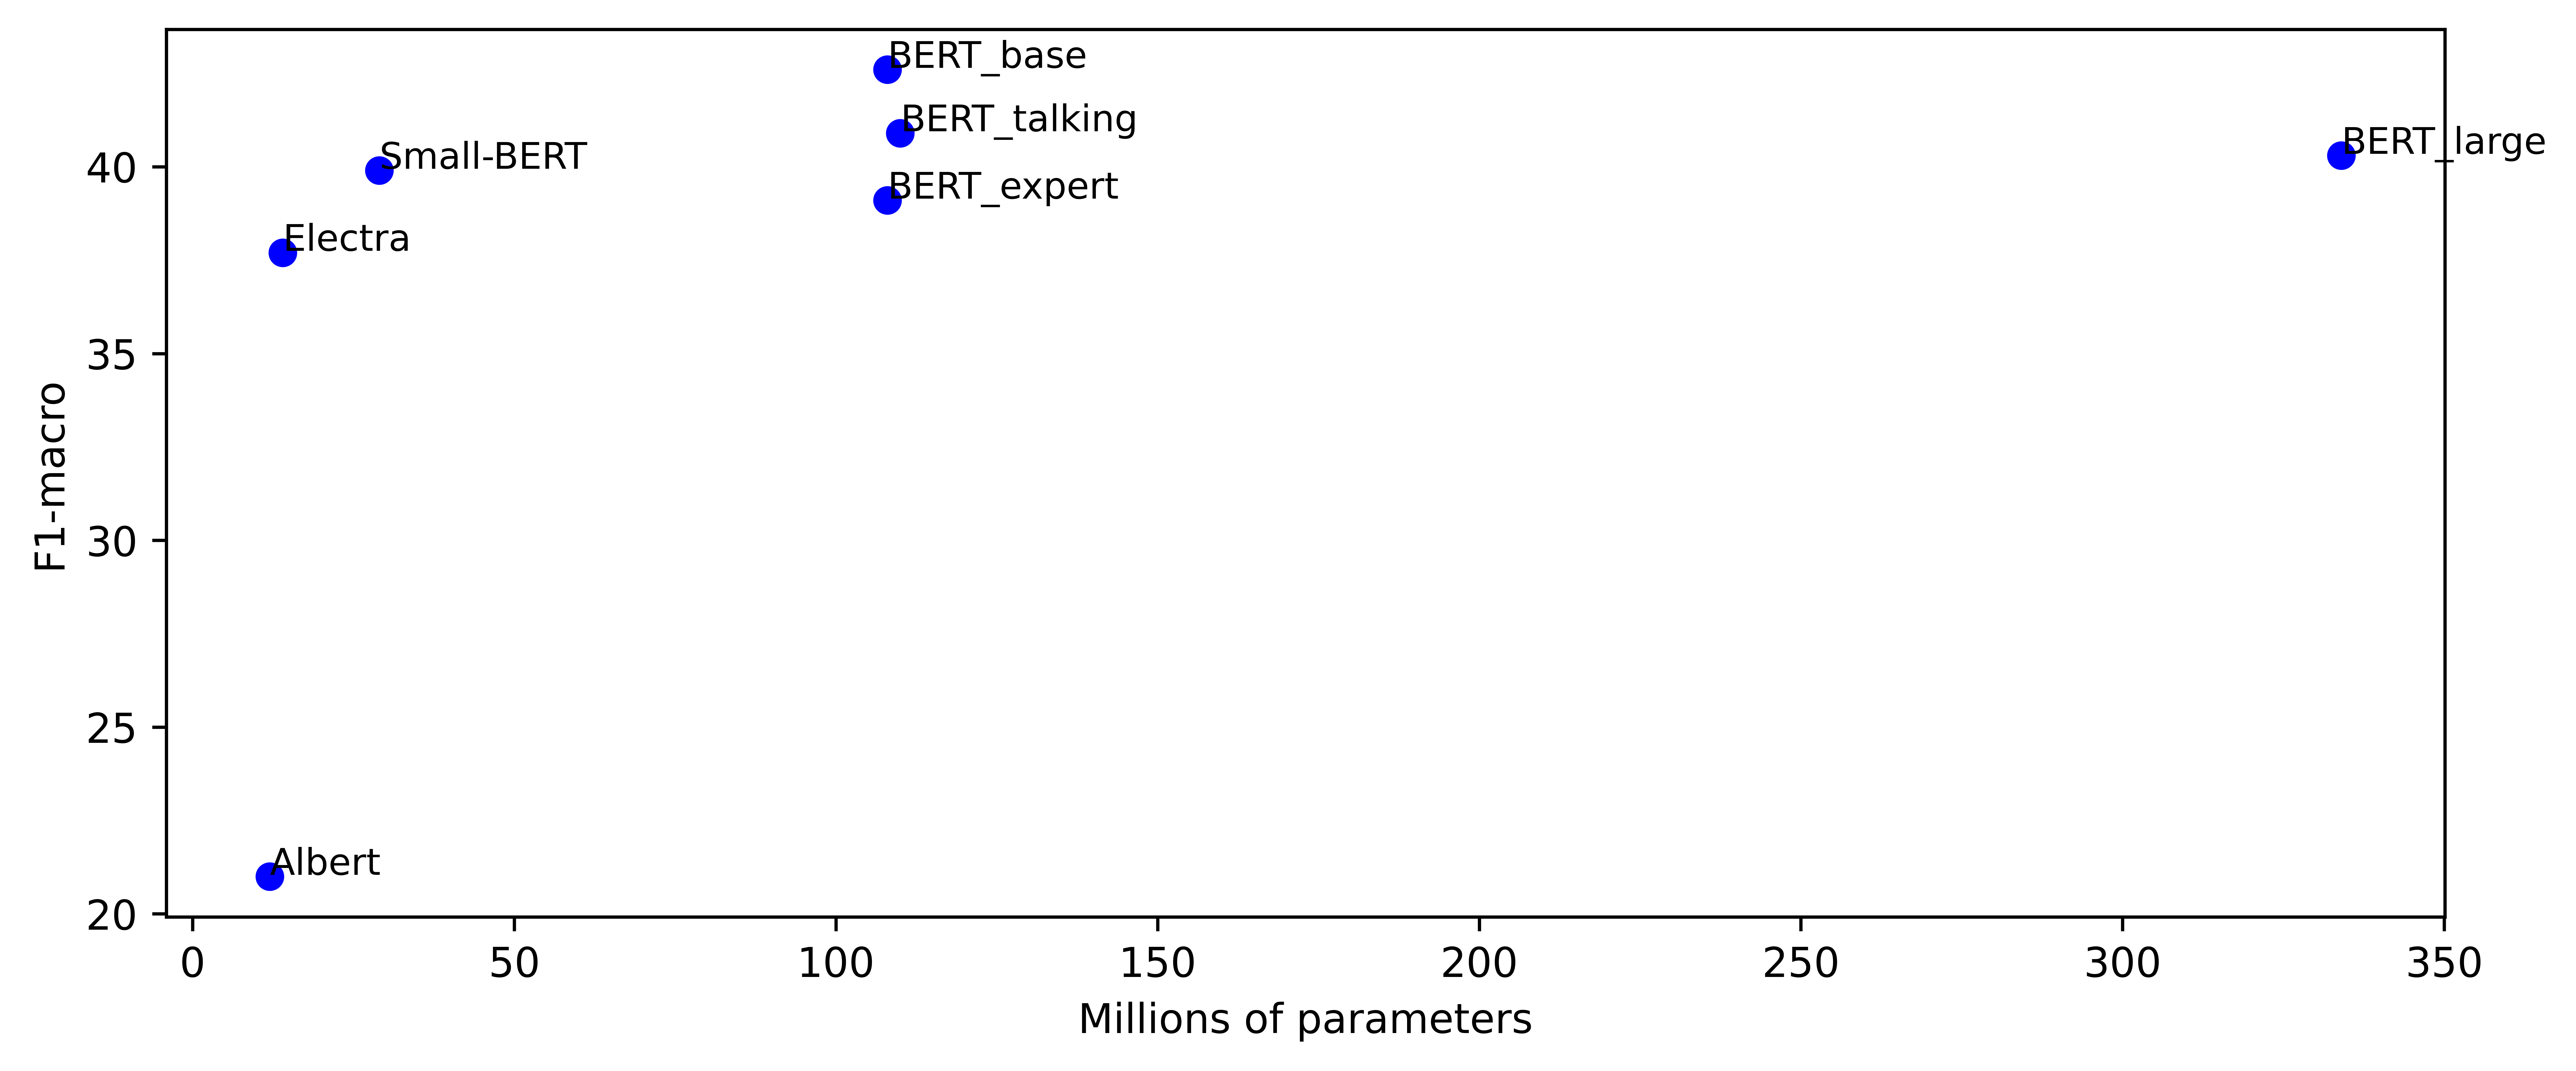

In [ ]:
plot_metric_parameter(F1_macro[1:], parameter_size_num, models[1:], "Millions of parameters", "F1-macro")

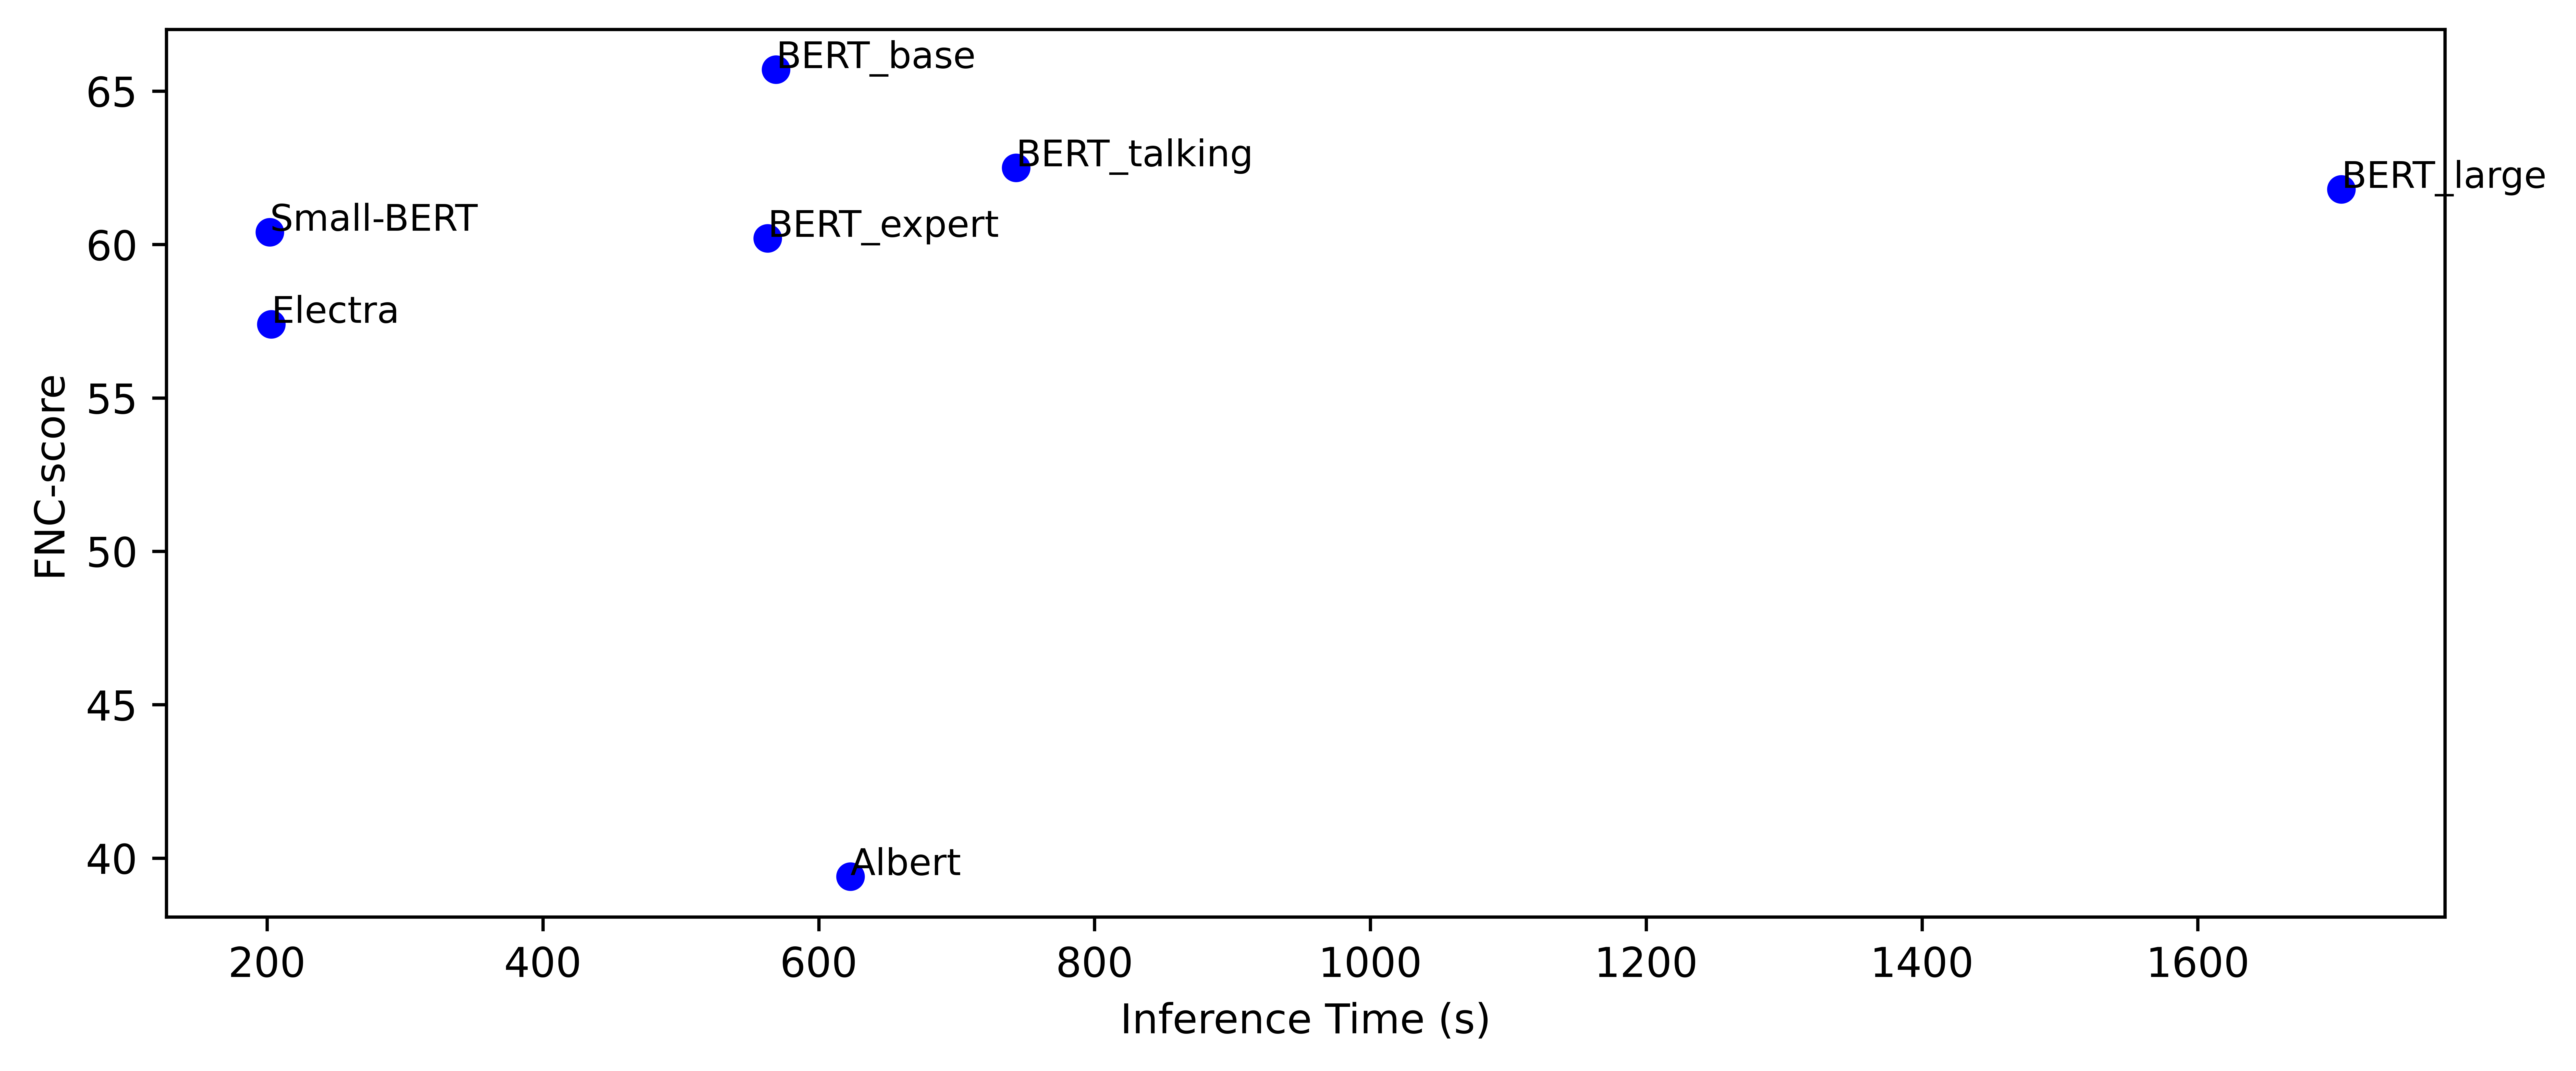

In [ ]:
plot_metric_parameter(FNC_score[1:], inference_time[1:], models[1:], "Inference Time (s)", "FNC-score")

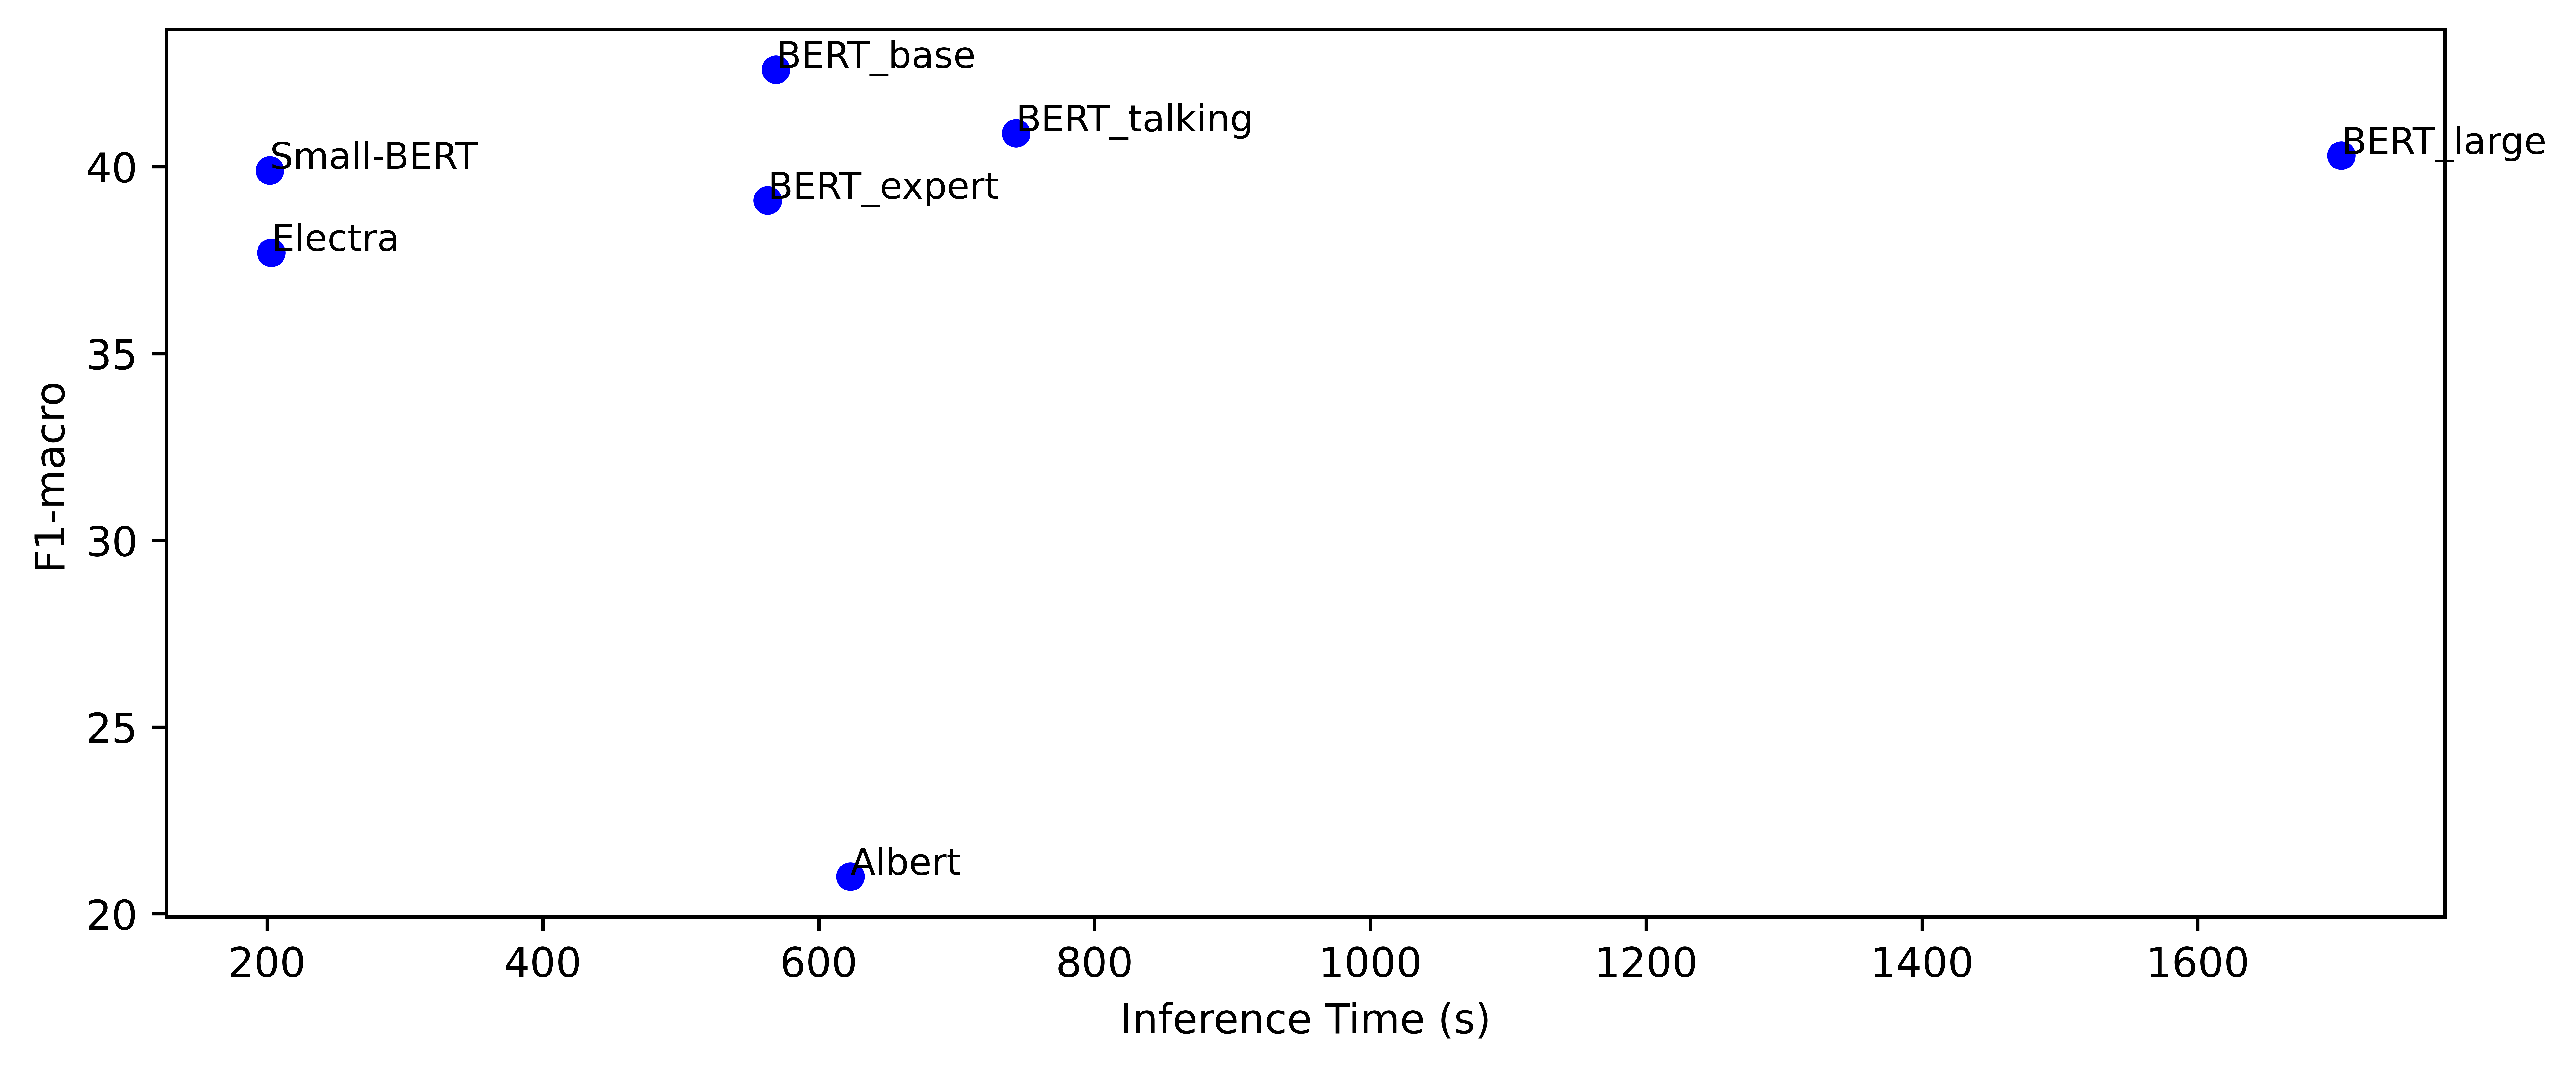

In [ ]:
plot_metric_parameter(F1_macro[1:], inference_time[1:], models[1:], "Inference Time (s)", "F1-macro")